# HealSparse tutorial

In this tutorial you will learn about the basic functionality of HealSparse. Please let us know of any issues/questions [here](https://github.com/LSSTDESC/healsparse/issues).

`HealSparse` is a Python package that uses [`healpy`](https://github.com/healpy/healpy) to generate sparse [`HEALPix`](https://healpix.jpl.nasa.gov/).

While `healpy` is very convenient and powerful for analyzing full-sky maps, when dealing with partial sky-coverage, it introduces a large memory overhead since the empty pixels are carried over, making it difficult to deal with high-resolution maps. `HealSparse` tries to take advantage of all the power and convenience of `healpy` while trying to reduce the memory footprint.

`HealSparse` has the ability to create maps using `ndarray` and `recarray` objects. In a single-grid, it can contain several maps. This can be useful to map observing conditions, or to carry information about galaxy density, and shear. Or CMB temperatures and polarizations in the same grids.

## Basics

* How does `HealSparse` manage to reduce the memory footprint while retaining most of `healpy`'s functionalities? 

`HealSparse` uses a dual-map approach, i.e., we use a low-resolution, full-sky "coverage index map" that tells us about the patches of the sky that are observed/contain relevant information. The size of this map is controlled by the parameter: `nside_coverage`. Then, for each one of the covered pixels, we store the information about the high-resolution pixels contained in it. The resolution of these fine-grid pixels is controlled by the `nside_sparse` parameter. This means that, in principle, we store `n_covered * (nside_sparse/nside_coverage)**2` pixels, in this case in a 1D `numpy` array, where `n_covered` is the number of observed or covered pixels in the coverage map. However, for convenience reasons, we have an overflow bin (which goes from `[0:(nside_sparse/nside_coverage)**2]`).

In [1]:
import numpy as np
import healsparse as hsp
import healpy as hp
import matplotlib.pyplot as plt
import sys
%matplotlib inline

### Creation of a `HealSparseMap`

Let's get started by creating a simple `HealSparse` map. There are several ways to do so:

**1) Using a previously generated `healpy` map.**

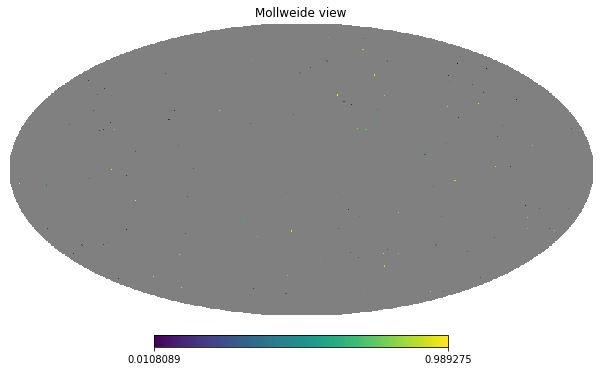

In [2]:
# These values are going to control the resolution of the maps
nside_coverage = 32 # This is going to control the resolution of the "low-resolution map" that tells us which pixels are covered
nside_sparse = 128 # This is going to control the resolution of the "high-resolution" map that contains the information that we care about
n_pop = 200
ra_rnd = 360.0*np.random.random(size=n_pop)
dec_rnd = -90.0 + 180.0*np.random.random(size=n_pop)
value_rnd = np.random.random(size=n_pop)
hp_aux = np.zeros(hp.nside2npix(nside_sparse)) + hp.UNSEEN # Empty pixels for `HealSparse` are marked by `hp.UNSEEN`
hp_aux[hp.ang2pix(nside_sparse, np.radians(90 - dec_rnd), np.radians(ra_rnd), nest=True)] = value_rnd
hp.mollview(hp_aux)

In [3]:
# Now let's create the `HealSparseMap`
hsp_map = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=hp_aux)

In [4]:
# Now let's check the size savings
print('Size of Original HEALPix map [KB] ', sys.getsizeof(hp_aux)/1024.)
print('Size of HealSparse Map [KB]:' ,sys.getsizeof(hsp_map._sparse_map)/1024.)
print('Memory footprint reduction factor:', int(1.0*sys.getsizeof(hp_aux)/sys.getsizeof(hsp_map._sparse_map)))
# We reduce a factor of 62!! But this is mostly due because the map is very sparse

Size of Original HEALPix map [KB]  1536.09375
Size of HealSparse Map [KB]: 24.59375
Memory footprint reduction factor: 62


**2) From scratch:**

In [5]:
# First create an empty map of the desired size and coverage
hsp_map_2 = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, dtype=np.float)
# Get the pixel index corresponding to the position in the sky that we care about (we use the same convention as healpy!!)
pixels = hp.ang2pix(nside_sparse, np.radians(90 - dec_rnd), np.radians(ra_rnd), nest=True)
# Populate the map (using the same values and positions as in the previous case)
hsp_map_2.update_values_pix(pixels, value_rnd)
# Check that both maps are the same
print('Are both maps (the one generated from scratch and the one generated from the HEALPix map) the same?', np.allclose(hsp_map._sparse_map,hsp_map_2._sparse_map))

Are both maps (the one generated from scratch and the one generated from the HEALPix map) the same? True


The values in the map are contained in their `_sparse_map` attributes

The main advantage of `healsparse` is the ability to generate very high-resolution maps which would not be possible to create with `healpy` otherwise. For example:

In [6]:
nside_coverage = 1024
nside_sparse = 32768 # A HEALPix map of this resolution would need ~96 GB of memory
# Generate the empty map
hsp_map_high_res = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, dtype=np.float)
# Fill it up at the same positions as before
pixels = hp.ang2pix(nside_sparse, np.radians(90 - dec_rnd), np.radians(ra_rnd), nest=True)
hsp_map_high_res.update_values_pix(pixels, value_rnd)
print('Size of HealSparse Map [KB]:' ,sys.getsizeof(hsp_map_high_res._sparse_map)/1024., ' with resolution: ', 60*hp.nside2resol(nside_sparse, arcmin=True), ' arcsec')

Size of HealSparse Map [KB]: 1608.09375  with resolution:  6.441537022157636  arcsec


### Input/Output

`HealSparse` can read and write both `HealSparse` maps and `HEALPix/healpy` maps

In [7]:
nside_coverage = 32 
nside_sparse = 128
# Write both the HEALPix and HealSparse maps
hp.write_map('test_hp_map.fits', hp_aux, overwrite=True)
hsp_map.write('test_hsp_map.fits', clobber=True)
# Read both the HEALPix and HealSparse maps using HealSparse
hsp_map_3 = hsp.HealSparseMap.read('test_hp_map.fits', nside_coverage=nside_coverage)
hsp_map_4 = hsp.HealSparseMap.read('test_hsp_map.fits')

### Coverage mask and map

A useful property of `HealSparse` objects are their **"coverage masks"**. These masks are boolean maps that show the low-resolution pixels that contain non-empty high-resolution pixels with value `1`, and the empty pixels with value `0`. In order to access these masks we have to use the property/method `coverage_mask` from a `HealSparse` object. Let's see an example:

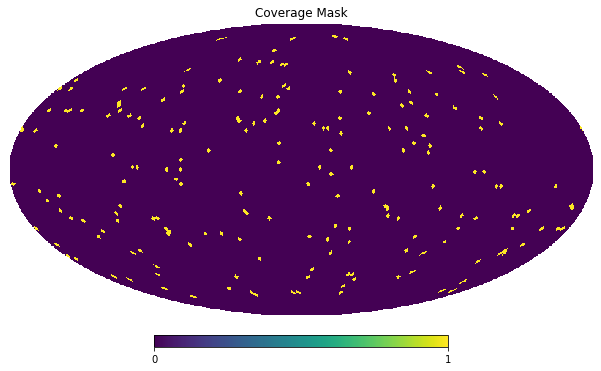

In [8]:
hsp_mask = hsp_map.coverage_mask
hp.mollview(hsp_mask, title='Coverage Mask')

Another useful property of `HealSparse` objects are their **"coverage maps"**. These maps show what fraction of a pixel in the low-resolution map has been observed in the high-resolution map. E.g., if a low-resolution pixel contains high-resolution pixels that have been all observed, the value of the coverage map in that pixel will be 1.0. In order to access these maps, one just has to invoke the method `HealSparse.coverage_map`

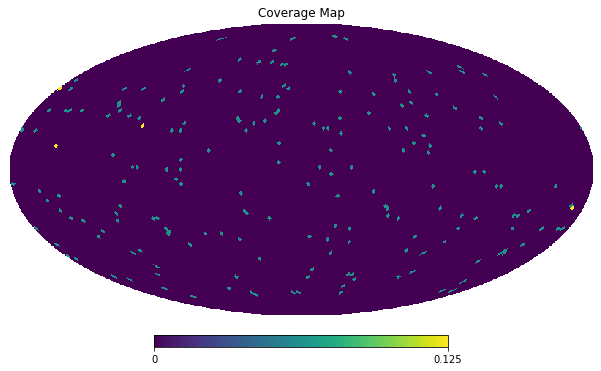

In [9]:
hsp_cov_map = hsp_map.coverage_map
hp.mollview(hsp_cov_map, title='Coverage Map')

### Pixel utilities

`HealSparse` also has utilities to get the value of a pixel in a given position of the sky, or update a map in a given position. Let's see how this is done:

In [10]:
# Points to probe
test_ra = 360*np.random.random(size=10)
test_dec = -90 + 180*np.random.random(size=10)
# Values to recover
test_values = hsp_map.get_values_pos(test_ra, test_dec, lonlat=True)
# There's also the possiblity of getting them from the theta/phi coordinates:
test_values_2 = hsp_map.get_values_pos(np.radians(90 - test_dec), np.radians(test_ra), lonlat=False)
print('Are all the pixel values the same using both methods?', np.allclose(test_values, test_values_2))

Are all the pixel values the same using both methods? True


An alternative method to get the value in a given pixel is to get the `HEALPix` pixel number that corresponds to a given position (RA, Dec) with the same resolution that our sparse map, and query these:

In [11]:
test_px_num = hp.ang2pix(hsp_map._nside_sparse, np.radians(90 - test_dec), np.radians(test_ra), nest=True)
test_values_2 = hsp_map.get_values_pix(test_px_num)
print('Are all the pixel values the same using both methods?', np.allclose(test_values, test_values_2))

Are all the pixel values the same using both methods? True


Now, if you want to change the value of a `HealSparseMap` the preferred option is to use the `update` method given the pixel number

In [12]:
test_values = np.random.random(size=10)
# Now let's update the map in the positions that we were previously probing.
hsp_map.update_values_pix(test_px_num, test_values)

### Checking the position of valid pixels

`HealSparse`'s high-resolution maps follow the same indexing as their `HEALPix` counterparts using the `NEST` pixel scheme. `HealSparse` maps have methods to quickly access the indices of pixels of the high-resolution maps that have been observed (i.e., that have a value different than the sentinel).

In [14]:
valid_pixels_indices = hsp_map.valid_pixels
print(valid_pixels_indices) # These are the indices of the HEALPixels with nside=1024 that have been observed

[  3426   3545   3728   4097   6870   8795  13655  13663  14888  14941
  16240  16270  18615  19627  21841  21969  22278  23473  23836  26307
  26893  27463  29836  30250  31799  32067  32406  32489  32719  32765
  32767  34052  34289  35396  35688  37328  37595  37987  38059  39155
  40489  42710  43602  44751  45682  47538  48211  48823  48974  49017
  49036  49095  50273  51975  52864  52949  53804  54519  54893  55649
  56187  56461  56559  57218  57987  58554  58801  59695  60373  60994
  60999  63497  63863  64141  64205  64426  64436  64709  64952  64986
  65472  65532  68479  69382  70223  74833  76415  77664  77677  78387
  81225  82581  82834  84547  85651  89511  91217  93938  95817  95830
  96495  97118  97226  97702  97759 100749 100783 103321 105914 108153
 109989 110584 111584 112779 112968 112985 113211 116654 117517 117978
 120677 121733 124821 128660 129077 129750 131105 131111 131597 131788
 132309 132363 132989 133327 134350 134823 137454 137458 137659 137930
 13836

We can also quickly get their positions by using the `valid_pixels_pos` method. This method internally calls `healpy.pix2ang` and accepts the `lonlat` option which allows you to either retrieve the positions as colatitude and longitude in radians or RA and Dec in degrees.

Pixel resolution: 0.46 deg


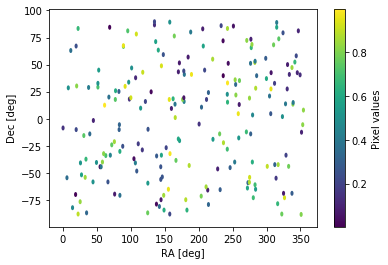

In [38]:
ra_valid, dec_valid = hsp_map.valid_pixels_pos(lonlat=True)
hsp_map_values = hsp_map.get_values_pos(ra_valid, dec_valid, lonlat=True)
size = 1./60*hp.nside2resol(nside_sparse, arcmin=True) # Get the resolution of the pixel
print('Pixel resolution: %.2f deg' % (size))
# Let's take a look, approximating each pixel as Circles with radius = resolution/2
# We will draw circles 10 times larger than they should so we can see them in this map
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
# This visualization is not accurate but it helps
patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(ra_valid, dec_valid, 10*size/2)]
collection = PatchCollection(patches)
collection.set_array(np.asarray(hsp_map_values))
f, ax = plt.subplots(1,1)
ax.add_collection(collection)
ax.autoscale_view()
plt.sci(collection)
plt.colorbar(label='Pixel values')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]');

### Using `np.recarray`

A very powerful feature of `HealSparse` is the ability to deal with `np.recarray`. This allows us to carry several maps on the same "grid" and using the same coverage mask/map. Let's see an example of how to create such maps.

In [13]:
# We are going to create 3 maps: one with galaxy overdensity, another with number of stars (integer), and one with sky-brightness
dtype = [('gal_delta','f8'),('star_num','i4'),('sky_brightness','f4')]
npop = 10000 # We are going to populate 10000 pixels
ra_rnd = 360*np.random.random(size=npop)
dec_rnd = -90 + 180.0*np.random.random(size=npop)
nside_sparse = 512 # This is the resolution for our sparse map
nside_coverage = 32 # This is the resolution of our coverage map
# We are going to fill up the pixels corresponding to the positions above 
px_rnd = hp.ang2pix(nside_sparse, np.radians(90 - dec_rnd), np.radians(ra_rnd), nest=True)
# Create an empty array
test_arr = np.zeros(npop, dtype=dtype)
# Fill up the arrays with random values
test_arr['gal_delta'] = -1 + 10*np.random.random(npop)
test_arr['star_num'] = np.random.randint(low=0, high=10, size=npop)
test_arr['sky_brightness'] = 3000 + 10000*np.random.random(size=npop)
hsp_recarray = hsp.HealSparseMap.make_empty(nside_coverage, nside_sparse, dtype=dtype, primary='gal_delta') # A primary key should be chosen! This marks our "primary" map
hsp_recarray.update_values_pix(px_rnd, test_arr)

`hsp_recarray` now contains information about 3 maps in its `_sparseMap` and the primary key is `gal_delta` (the galaxy overdensity map)

In [14]:
print(hsp_recarray._sparse_map.dtype.fields)

{'gal_delta': (dtype('float64'), 0), 'sky_brightness': (dtype('float32'), 12), 'star_num': (dtype('int32'), 8)}


### Changing the resolution of a `HealSparseMap`

We can decrease the resolution of a given `HealSparseMap` using the `degrade` method. This method allows us to keep the same coverage index map and change the size of the sparse map(s). This method is pretty flexible and, it gives the user the possibility of choosing several methods to change the resolution of the original maps, including, mean, median, standard deviation, maximum or minimum. So, the value of the new (larger) pixel will correspond to the chosen operation performed on the smaller (sub-)pixels. 

In [15]:
# The method works for `HealSparseMap` containing both `recarray`s and `ndarray`s
low_res_hsp = hsp_recarray.degrade(64) # It changes the resolution of all maps
print('What is my new nside_sparse?', low_res_hsp._nside_sparse)
# Warnings arise due to operations in the overflow bin but they can be safely ignored

What is my new nside_sparse? 64


/Users/javiers/gitrepos/downloads/healsparse/healsparse/utils.py:20: RuntimeWarning: Mean of empty slice
  return np.nanmean(x, axis=2).flatten()


In [16]:
low_res_hsp = hsp_recarray.degrade(64, reduction='max') # We can also check the maximum, for example
print('What is my new nside_sparse?', low_res_hsp._nside_sparse)

What is my new nside_sparse? 64


/Users/javiers/gitrepos/downloads/healsparse/healsparse/utils.py:26: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x, axis=2).flatten()


### Getting a HEALPix map from a HealSparse map

Another useful utility of `HealSparse` is the ability to build a `HEALPix` map from a given `HealSparse` map. This utility also allows the user to change the resolution of the map before converting to `HEALPix` (this can prevent running into memory problems). In the case of using `recarray` maps, the user can choose which map they want to convert. The datatypes are preserved, except in the case of dealing with integers, in that case, the maps are converted to floating point.

/Users/javiers/gitrepos/downloads/healsparse/healsparse/utils.py:20: RuntimeWarning: Mean of empty slice
  return np.nanmean(x, axis=2).flatten()


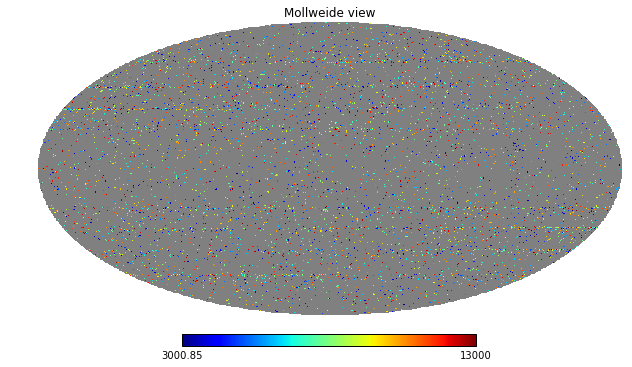

In [17]:
rec_hp = hsp_recarray.generate_healpix_map(nside=128, key='sky_brightness')
hp.mollview(rec_hp)

You are now ready to use `healsparse`! Please let us know of any [issues](https://github.com/LSSTDESC/healsparse/issues).